# Computing Structural Relaxation

## What is structural relaxation

Structural relaxation is a key concept for studying
the dynamics of supercooled liquids,
being the most fundamental relaxation process (Angell 2000).
It is the process by which
a liquid forgets it's structure from some earlier time (Edger 1996),
and can be measured experimentally through
quasi-elastic neutron scattering or photon correlation spectroscopy.
These experimental techniques are measuring
the density-density correlations of the liquid,
which can be represented by either
the density autocorrelation function,
or as is more common the intermediate scattering function $F(k, t)$.
This function is represented as

$$ F(k, t) = \frac{1}{N}\langle \sum_j^N \exp{
    i\mathbf{k} \cdot [\mathbf{r}_j(0) - \mathbf{r}_j(t)]
} \rangle $$

where the angle brackets denote the averaging over
many initial configurations.

The intermediate scattering function is
the spatial Fourier transform of the
van Hove correlation function $G(r, t)$
which is a much quantity to calculate
from simulated systems.
The van Hove correlation function is given as;

$$G(r, t) = \frac{1}{4\pi r^2 \Delta r} \langle \delta[r_i(t) - r_i(0) - r] \rangle$$

Instead of computing the intermediate scattering function
for all values of the wave-vector $k$,
just a single value for the wave-vector is tracked through time.
The choice of this wave-vector is chosen as
peak of the static structure factor $S(k)$
as this is the largest and so has the biggest response.
The static structure factor $S(k)$
is the time independent version of
the intermediate scattering function.
The structure factor is computed from the
radial distribution function $G(r)$,
being the time independent part of the
van Hove correlation function.

The radial distribution function $G(r)$
is computed as

$$ G(r) = \frac{1}{N\rho} \sum_i^N \sum_{j\ne i}^N \delta[r - r_{ij}] $$

while the static structure factor $S(k)$
is the Fourier transform of
the radial distribution function

$$ S(q) = 1 + \rho \int dr e^{-iqr} [G(r) - 1] $$

## Computing the structural relaxation

This is a notebook for computing
the structural relaxation of
a molecular dynamics trajectory
which contains 675 trimer molecules.

### Loading the trajectory

The first step here is to load the trajectory for analysis.
For this step I have written a helper function
to make this process simpler
which is contained within the `sdanalysis` package.

In [1]:
# Import sdanalysis to read input files
import sdanalysis

The input file which we want to read
is for an exponential sequence of steps
at a relatively high temperature
so that we don't have to read
too many steps of the trajectory,
that is, everything will go faster.
The temperature which I am choosing will be 0.80
at a pressure of 1.0

In [2]:
temperature = 0.80
pressure = 1.00

# This is a python standard library module which makes handling paths
# significantly simpler
from pathlib import Path

# Path to the directory holding the input files
data_directory = Path("../data/simulations/trimer/output")

filename = data_directory / f"trajectory-Trimer-P{pressure:.2f}-T{temperature:.2f}.gsd"

With the path of the file to read
we now need to access the first configuration of the trajectory
which can be used to calculate the
radial distribution function.
The function `sdanalysis.open_trajectory` returns an iterator,
so to get the first snapshot from the file
we have to use the `next` function.

In [3]:
init_snapshot = next(sdanalysis.open_trajectory(filename))

Getting the positions of particles
from the snapshot can be done by calling the
`position` property

In [4]:
init_snapshot.position

array([[-23.3865   ,  -9.239151 ,   0.       ],
       [  3.9658844, -22.591003 ,   0.       ],
       [ 12.305967 ,  14.258924 ,   0.       ],
       ...,
       [ 13.643798 , -16.695618 ,   0.       ],
       [ 16.10849  , -11.522567 ,   0.       ],
       [ 25.02609  , -14.913969 ,   0.       ]], dtype=float32)

Note that these are the positions for the
center-of-mass for each of the 625 molecules.
The positions of the individual particles
can be calculated from
the positions and orientations,
where the orientations in quaternion form
are accessed through the `orientation` property.

Additionally the description of box can be retrieved
with the `box` property

In [5]:
init_snapshot.box

array([62.86591, 62.86591,  1.     ,  0.     ,  0.     ,  0.     ],
      dtype=float32)

We can combine these properties of
the initial snapshot and calculate the
radial distribution function.

### Computing the radial distribution function

The Glotzer group have developed a python package
called [freud](https://github.com/glotzerlab/freud) for the analysis of
molecular dynamics trajectories.
This package includes a function
for computing the radial distribution function
[`freud.density.RDF`](https://freud.readthedocs.io/en/stable/density.html#freud.density.RDF)
I will be using this function for computing $G(r)$

In [56]:
# import the freud library
import freud

# The simulation box of the snapshot
box = freud.box.Box(
    Lx=init_snapshot.box[0],
    Ly=init_snapshot.box[1],
    is2D=True,
)

# This is the size of the bins for the distribution function
dr=0.1
# The maximum radius to integrate to, this has to be smaller than half the
# width of the box.
rmax=20
rdf = freud.density.RDF(rmax=rmax, dr=dr)

rdf.compute(box, init_snapshot.position)

This has calculated the radial distribution function
for the snapshot,
which we can plot using matplotlib.

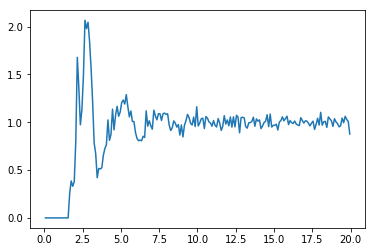

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(rdf.R, rdf.RDF)

It is possible to read many configurations
and use the function `rdf.accumulate`
instead of `rdf.compute`
to generate a smoother curve.

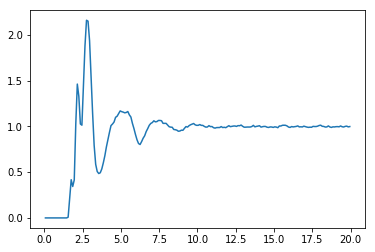

In [8]:
# This is the size of the bins for the distribution function
dr=0.1
# The maximum radius to integrate to, this has to be smaller than half the
# width of the box.
rmax=20
rdf = freud.density.RDF(rmax=rmax, dr=dr)

# Average over the first `num_frames` frames
num_frames = 1000
for index, snapshot in enumerate(sdanalysis.open_trajectory(filename)):
    if index > num_frames:
        break

    box = freud.box.Box(
        Lx=snapshot.box[0],
        Ly=snapshot.box[1],
        is2D=True,
    )
    rdf.accumulate(box, snapshot.position)

plt.plot(rdf.R, rdf.RDF)

### Computing the structure factor

Now that we have nicely computed the radial distribution function
we can convert it to the structure factor $S(k)$
the equation for which is below for reference.

$$ S(k) = 1 + \rho \int dr e^{-ikr} [G(r) - 1] $$

We are going to be taking the Fourier Transform of $G(r) -1$,
using the numpy implementation of the Fast Fourier transform,
[`numpy.fft.fft`](https://docs.scipy.org/doc/numpy-1.14.1/reference/routines.fft.html#module-numpy.fft).
Since I am not interested in the absolute magnitude of the peaks,
only their relative magnitude and position,
I will ignore the $1 +$ and $\rho$ terms.

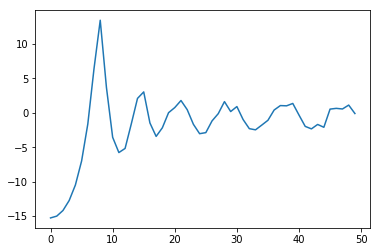

In [59]:
import numpy

structure_factor = numpy.fft.rfft(rdf.RDF - 1)

plt.plot(structure_factor[:len(structure_factor)//2])

In the numpy implementation the first N/2 wave-vectors are the positive ones
while the last N/2 are the negative ones.
To find the wave-vector which is most prominent
and we consequently want to track
for the time dependent scattering function
we can find the position of the maximum value

In [60]:
wave_vector = numpy.argmax(structure_factor)
wave_vector

8

Here we see that the maximum is 8,
so we want a wave-vector $k = 8$

### Calculating the intermediate scattering function

The intermediate scattering function is given by

$$ F(k, t) = \frac{1}{N}\langle \sum_j^N \exp{
    i\mathbf{k} \cdot [\mathbf{r}_j(0) - \mathbf{r}_j(t)]
} \rangle $$

where the scalar $k$ is the wave number,
and the vector $\mathbf{k}$ is the wave vector.

The relationship between
the wave number and the wave vector
is the type of wave we want to compute.
In the case of an isotropic liquid, that is,
the liquid is the same in all directions,
the wave we want is radially expanding in all directions,
which takes the form

$$ \mathbf{k} = k \frac{1}{M}\sum_a^M [\cos(\theta_a), \sin(\theta_a)] $$

Where the sum is over $N$ values of
the angle $\theta_i$ which ranges in value from $0$ to $2\pi$.

Substituting this value for $\mathbf{k}$
into our expression for the intermediate scattering function
we get

$$
F(t) = \frac{1}{N}\langle \sum_j^N\sum_a^M \exp{
8i [\cos(\theta_a), \sin(\theta_a)] \cdot [r_{j}(0) - r_{j}(t)]
} \rangle
$$

Additionally since we can only use the real component
this can be further simplified to

$$
F(t) = \frac{1}{N}\langle \sum_j^N\sum_a^M \cos{
8 [\cos(\theta_a), \sin(\theta_a)] \cdot [r_{j}(0) - r_{j}(t)]
} \rangle
$$

Additionally to simplify everything once more,
and since I am only using a single starting configuration here,
I am going to use the angle brackets to
denote a mean over all particles and angles.
Enabling me to write

$$ F(t) = \langle \cos(
8 [\cos(\theta_a), \sin(\theta_a)] \cdot [r_{j}(0) - r_{j}(t)]
) \rangle $$

This can then be converted to a python function:

In [ ]:
def intermediate_scattering_function(
    box: freud.box.Box,
    initial_position: numpy.ndarray,
    current_position: numpy.ndarray,
    wave_number: int,
    angular_resolution: int = 60,
) -> float:
    r"""Calculate the intermediate scattering function for a specific wave-vector

    This calculates the equation

    .. math::
        F(k, t) = \langle \cos(
            k [\cos(\theta_a), \sin(\theta_a)] \cdot [r_{x}(0) - r_{x}(t)]
        ) \rangle

    Where k is the value of `wave_number`, the values of the array `inital_position` are
    $r_x(0)$, while `current_position` is $r_(t)$. The number of values for the angle is
    give the `angular_resolution`.

    The values of initial_position and current_position are both expected to be a vector
    of shape N x 3 and the appropriate elements are extracted from it.

    """
    angles = numpy.linspace(0, 2*numpy.pi, num=angular_resolution, endpoint=False).reshape((-1, 1))
    wave_vector = numpy.concatenate([numpy.cos(angles), numpy.sin(angles)], axis=1)
    wave_vector *= wave_number

    displacement = box.wrap(initial_position - current_position)[:, :2]

    return numpy.mean(numpy.cos(numpy.dot(wave_vector, displacement.T)))

This function we have just written can now be used the compute
the structural relaxation for this trajectory.

In [54]:
timesteps = []
scattering_values = []
num_frames = 1000

for index, snapshot in enumerate(sdanalysis.open_trajectory(filename)):
    if index > num_frames:
        break

    box = freud.box.Box(
        Lx=snapshot.box[0],
        Ly=snapshot.box[1],
        is2D=True,
    )

    timesteps.append(snapshot.timestep)

    scattering_values.append(intermediate_scattering_function(
        box, init_snapshot.position, snapshot.position, wave_number=8, angular_resolution=360
    ))

And plotting the resulting values

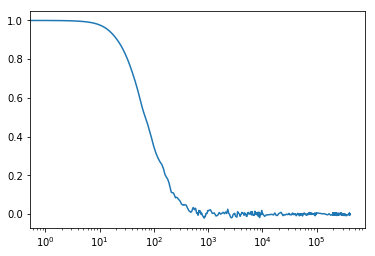

In [55]:
plt.plot(timesteps, scattering_values)
plt.xscale('log')